# Funcion deconSingleView traducida a JULIA solo para el backprojector 'traditional'

## SETUP

In [2]:
using DeconvOptim, Images, FFTW, Noise, ImageView, BenchmarkTools, Plots

### Funciones necesarias

In [3]:
function ConvFFT3_S(inVol, OTF)
    # Realiza la convolución 3D en el dominio de Fourier
    outVol = real(ifft(fft(inVol) .* OTF))
    return outVol
end

ConvFFT3_S (generic function with 1 method)

In [5]:
function flipPSF(inPSF)
    # Obtener las dimensiones de la PSF
    Sx, Sy = size(inPSF)
    Sz = 1  # Si la imagen es 2D, la tercera dimensión será de tamaño 1

    if ndims(inPSF) == 3
        Sz = size(inPSF, 3)
    end
    # Crear una matriz de ceros del mismo tamaño que la PSF de entrada
    outPSF = zeros(Sx, Sy, Sz)
    
    # Invertir la PSF en todas las dimensiones
    for i in 1:Sx
        for j in 1:Sy
            for k in 1:Sz
                outPSF[i, j, k] = inPSF[Sx - i + 1, Sy - j + 1, Sz - k + 1]
            end
        end
    end
    
    return outPSF
end


flipPSF (generic function with 1 method)

In [6]:
function align_size(img1, Sx2, Sy2, Sz2, padValue::Float64=0.0)
    # Obtener las dimensiones de la imagen de entrada
    Sx1, Sy1 = size(img1)
    Sz1 = 1  # Si la imagen es 2D, la tercera dimensión será de tamaño 1

    if ndims(img1) == 3
        Sz1 = size(img1, 3)
    end

    # Calcular las dimensiones máximas
    Sx = max(Sx1, Sx2)
    Sy = max(Sy1, Sy2)
    Sz = max(Sz1, Sz2)

    # Crear una matriz temporal rellena con el valor de relleno
    imgTemp = fill(padValue, Sx, Sy, Sz)

    # Calcular los índices de inicio para alinear la imagen
    Sox = round(Int, (Sx - Sx1) / 2) + 1
    Soy = round(Int, (Sy - Sy1) / 2) + 1
    Soz = round(Int, (Sz - Sz1) / 2) + 1

    # Asegurarse de que los índices no se salgan de los límites de la imagen temporal
    Sox = max(Sox, 1)
    Soy = max(Soy, 1)
    Soz = max(Soz, 1)

    # Colocar la imagen original en la matriz de relleno
    imgTemp[Sox:Sox+Sx1-1, Soy:Soy+Sy1-1, Soz:Soz+Sz1-1].= img1

    # Calcular los índices de la imagen resultante
    Sox = round(Int, (Sx - Sx2) / 2) + 1
    Soy = round(Int, (Sy - Sy2) / 2) + 1
    Soz = round(Int, (Sz - Sz2) / 2) + 1

    # Asegurarse de que los índices no se salgan de los límites de la imagen temporal
    Sox = max(Sox, 1)
    Soy = max(Soy, 1)
    Soz = max(Soz, 1)
    
    # Asegurarse de que las dimensiones 3D solo se usen si la imagen es 3D
    if Sz2 == 1
        img2 = imgTemp[Sox:Sox+Sx2-1, Soy:Soy+Sy2-1]
    else
        img2 = imgTemp[Sox:Sox+Sx2-1, Soy:Soy+Sy2-1, Soz:Soz+Sz2-1]
    
    end

    return img2
end
# Función principal de deconvolución

function deconvolve_image(imageStack, psfNormalized, iterations, smallValue=0.001)
    # Asegurarnos de que la imagen tiene 3 dimensiones (añadir una dimensión si es 2D)
    if ndims(imageStack) == 2
        imageStack = reshape(imageStack, size(imageStack, 1), size(imageStack, 2), 1)
    end
    
    Sx, Sy, Sz= size(imageStack)
    
    PSF_fp = align_size(psfNormalized, Sx, Sy, Sz)
    PSF2 = flipPSF(PSF_fp)
    PSF2 = PSF2 / sum(PSF2)
    PSF_bp = align_size(PSF2, Sx, Sy, Sz)
    
    # Inicialización de la estimación de la imagen
    stackEstimate = imageStack  # Usamos la imagen original para la inicialización
    stack = imageStack
    stack .= max.(stack,smallValue)

    # Proyectores en el dominio de Fourier
    OTF_fp = fft(ifftshift(PSF_fp))
    OTF_bp = fft(ifftshift(PSF_bp))  # Este es solo un ejemplo, en MATLAB hay una transformación más compleja

    # Deconvolución iterativa
    for i in 1:iterations
        # Realizamos la convolución en el dominio de Fourier utilizando las funciones correspondientes
        stackEstimate = stackEstimate .* ConvFFT3_S(stack ./ ConvFFT3_S(stackEstimate, OTF_fp), OTF_bp)
        
        # Aplicamos el valor mínimo para evitar valores negativos o pequeños
        stackEstimate .= max.(stackEstimate, smallValue)
    end    
    
    return stackEstimate
end

deconvolve_image (generic function with 2 methods)

In [9]:
using FileIO
using Images

function load_image_stack(folder_path::String)
    # Listar todos los archivos en la carpeta y ordenar
    files = sort(filter(f -> endswith(f, ".tif") || endswith(f, ".png") || endswith(f, ".jpg"), readdir(folder_path)))

    # Leer la primera imagen para obtener las dimensiones
    first_image = load(joinpath(folder_path, files[1]))
    height, width = size(first_image)

    # Crear una matriz 3D vacía para almacenar las imágenes
    image_stack = Array{Float32, 3}(undef, height, width,length(files))

    # Leer el rango de valores para normalización
    max_val = Float32(maximum(first_image)) # Valor máximo para normalización

    # Cargar cada imagen en la matriz 3D y convertir a Float32
    for (i, file) in enumerate(files)
        image = load(joinpath(folder_path, file))
        image_stack[:, :, i] = Float32.(image) / max_val
    end
    
    return image_stack
end

load_image_stack (generic function with 1 method)

### Código principal

Prueba realizada para unas matrices 2D definidas

In [7]:
using FFTW

# Crear una matriz de unos de 5x5
imageStackT = ones(5, 5)

# Asignar valores a posiciones específicas
imageStackT[2, 2] = 2.5
imageStackT[3, 3] = 2.8
imageStackT[4, 4] = 2
imageStackT[2, 3] = 1.5
imageStackT[2, 4] = 2.5
imageStackT[3, 2] = 2.8

psfStackT = zeros(5, 5)
psfStackT[3, 3] = 1
psfStackT[2, 2] = 1
psfStackT[2, 3] = 1
psfStackT[2, 4] = 1
psfStackT[3, 2] = 1
psfStackT[3, 4] = 1
psfStackT[4, 2] = 1
psfStackT[4, 3] = 1
psfStackT[4, 4] = 1

# Normalización de la PSF (como en MATLAB)
psfNormalized = psfStackT / sum(psfStackT)

deconvolved_image = deconvolve_image(imageStackT, psfNormalized, 1)


5×5×1 Array{Float64, 3}:
[:, :, 1] =
 0.951379  0.934071  1.03264   0.949865  0.964348
 0.989195  2.62168   1.72428   2.43257   0.893958
 0.979768  2.87844   3.38824   1.0499    0.974657
 0.954218  1.00453   1.06148   1.93237   0.913916
 0.875565  0.833856  0.895315  0.909168  0.954581

Prueba con la imagen en 3D C.Elegans

#### Canal 1

In [10]:
# Ruta a la carpeta que contiene las imágenes Z-stack
imagePath = "/Users/yi/TFGNotebook/CElegans-CY3"
psfPath = "/Users/yi/TFGNotebook/PSF-CElegans-CY3"

# Cargar las imágenes en una matriz 3D
image_stack = load_image_stack(imagePath)[1:356, 1:336, :]
psf_stack = load_image_stack(psfPath)[179:534, 169:504,:] #mitad +152

#save("imagenOriginal_CANAL1.png", image_stack[52, :, :]/maximum(image_stack))
psf_stack_normalizada = psf_stack / sum(psf_stack)
println("Suma de PSF normalizada: ", sum(psf_stack_normalizada))

# Verificar las dimensiones de las matrices 3D
println(size(image_stack))

println(size(psf_stack))
maximum(image_stack)

#image_stack[:, :,52]

deconvolved_image = deconvolve_image(image_stack, psf_stack_normalizada, 100)
deconvolved_image[:,:,52]

Suma de PSF normalizada: 0.99999994
(356, 336, 104)
(356, 336, 104)


356×336 Matrix{Float64}:
 0.001  0.001  0.001  0.001  0.001  …  0.001       0.001       0.001
 0.001  0.001  0.001  0.001  0.001     0.001       0.001       0.001
 0.001  0.001  0.001  0.001  0.001     0.001       0.001       0.001
 0.001  0.001  0.001  0.001  0.001     0.001       0.001       0.001
 0.001  0.001  0.001  0.001  0.001     0.001       0.001       0.001
 0.001  0.001  0.001  0.001  0.001  …  0.001       0.001       0.001
 0.001  0.001  0.001  0.001  0.001     0.001       0.001       0.001
 0.001  0.001  0.001  0.001  0.001     0.001       0.001       0.001
 0.001  0.001  0.001  0.001  0.001     0.001       0.001       0.001
 0.001  0.001  0.001  0.001  0.001     0.001       0.001       0.001
 ⋮                                  ⋱                          ⋮
 0.001  0.001  0.001  0.001  0.001     0.418583    0.076972    0.00945477
 0.001  0.001  0.001  0.001  0.001     0.392399    0.0692347   0.00816111
 0.001  0.001  0.001  0.001  0.001     0.348316    0.0601339   0.0065843

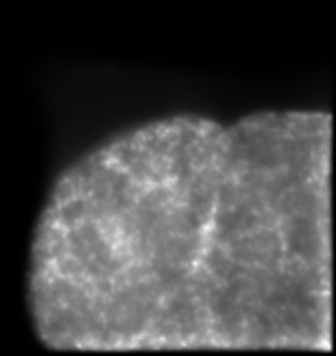

In [17]:
colorview(Gray, deconvolved_image[:,:,52]/maximum(deconvolved_image[:,:,52]))

In [19]:
save("Julia_CANAL1_100iter.png", deconvolved_image[:,:,52]/maximum(deconvolved_image[:,:,52]))

In [14]:
@benchmark deconvolve_image(image_stack, psf_stack_normalizada, 100) samples=1

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 154.629 s (7.31% GC) to evaluate,
 with a memory estimate of 186.67 GiB, over 4032 allocations.